In [1]:
import torch
import numpy as np
from transformers import BertTokenizer
from wikipedia2vec import Wikipedia2Vec
import time
import csv
import warnings
import logging

In [2]:
from utils import *
from data_processor import DataProcess
from bert_model import Bert, BertConfig
from entity_model import EntityModelConfig, EntityEncoder
from bert_trainer import BertTrainer, BertTrainerConfig
from entity_trainer import EntityTrainer, EntityTrainerConfig

In [3]:
warnings.filterwarnings('ignore')
logging.basicConfig(
        format="%(asctime)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)
logger = logging.getLogger(__name__)

In [4]:
set_seed(42)

In [5]:
# use pretrained bert model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [6]:
# use pretrained wiki_vector model
model_file = '/data/suyinpei/wiki_vector.model'
wiki2vec = Wikipedia2Vec.load(model_file)

## Data process

In [7]:
batch_size = 32 # batch size
en_pad_size = 12 # max entity number of one data
en_embd_dim = 100 # entity embedding dim
idf_file = '/data/suyinpei/idf_bigram5.txt'
entity_frep_file = '/data/suyinpei/entity_frep.tsv'
data_root = "/data/suyinpei/all_data_1028.tsv" # data: docid, text, entities, label
text_id_root = "/data/suyinpei/text_ids_1028.pt" # data_size * 512
labels_root = "/data/suyinpei/labels_1028.pt" # data_size
entity_id_root = "/data/suyinpei/entity_ids_1028.pt" # data_size * 12
entity_length_root = "/data/suyinpei/entity_length_1028.pt" # data_size
entity_vector_root = "/data/suyinpei/entity_vectors_1028.pt" # en_vocab_size * 100
entity_distribute_root = "/data/suyinpei/entity_distribute_1028.pt" # data_size

In [8]:
processor = DataProcess(data_root, text_id_root, labels_root, entity_id_root, entity_length_root, entity_distribute_root)

In [9]:
# # run this when using new data, build text index and label
# all_input_ids, labels = processor.encode_text(tokenizer)

In [10]:
# get entity vocab for predict
entity_to_index, index_to_entity = processor.build_entity_vocab()

11/04/2020 08:00:17 - All Entity number: 7744598
11/04/2020 08:00:25 - Entity vocab size: 1600870


In [11]:
# run this when need compute entity vector 
idf_dict, unk_idf = processor.load_idf(idf_file)

In [12]:
# # run this when use new data, build entity vector and index
# build_entity_vector = processor.build_entity_vector(entity_to_index, index_to_entity, wiki2vec, idf_dict, unk_idf, en_embd_dim, entity_vector_root)
# all_entity_ids, all_entity_length = processor.build_entity_id(entity_to_index, index_to_entity, en_pad_size)

In [13]:
entity_distribute_dict = processor.load_entity_distribute_dict(entity_frep_file)

11/04/2020 08:01:10 - Entity distribute vocab size: 667095


In [14]:
# run this when use new data, build entity vector and index
entity_distribute = processor.build_entity_distribute(entity_distribute_dict)

11/04/2020 08:01:38 - Entity distribute shape: torch.Size([508577])


In [15]:
entity_vector = processor.load_entity_vector(entity_vector_root) # get pretrained entity_vector

11/04/2020 08:01:38 - Entity vector shape: torch.Size([1600870, 100])


In [16]:
all_dataloader, train_dataloader, valid_dataloader = processor.load_data(ratio=0.8, batch_size=32) # build train/valid dataloader

11/04/2020 08:01:39 - Num of all_dataloader: 15894
11/04/2020 08:01:39 - Num of train_dataloader: 12715
11/04/2020 08:01:39 - Num of valid_dataloader: 3179


## Bert

In [17]:
bert_conf = BertConfig(model_name)

In [18]:
bert = Bert(bert_conf)

In [19]:
bert.fix_layer_grad(fix_layer=11)

11/04/2020 08:01:43 - Bert : all params: 109.484545M
11/04/2020 08:01:43 - Bert : need grad params: 7.680769M


## Entity Model

In [20]:
entity_model_conf = EntityModelConfig(entity_vector, en_embd_dim, en_hidden_size1=128, en_hidden_size2=128)

In [21]:
entity_model = EntityEncoder(entity_model_conf)

In [22]:
entity_model

EntityEncoder(
  (en_embeddings): Embedding(1600870, 100)
  (ln1): LayerNorm((100,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (mlp): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): GELU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (ln2): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## Bert Training

In [50]:
bert_tconf = BertTrainerConfig(max_epochs=1, learning_rate=6e-4, lr_decay=True, 
                      warmup_tokens=32*200, final_tokens=1*batch_size*len(train_dataloader),
                      num_workers=1, ckpt_path='../models/bert_model.pt')

max_epochs 1
learning_rate 0.0006
lr_decay True
warmup_tokens 6400
final_tokens 406880
num_workers 1
ckpt_path ../models/bert_model.pt


In [51]:
bert_trainer = BertTrainer(bert, train_dataloader, valid_dataloader, bert_tconf)

11/03/2020 09:12:08 - use device: cuda


In [52]:
# start training
bert_trainer.train()

epoch 1 iter 12714: train loss 0.00832. score 1.00000. lr 6.000000e-05: 100%|██████████| 12715/12715 [1:20:15<00:00,  2.64it/s]
11/03/2020 10:48:47 - test loss: 0.07629033457531766
11/03/2020 10:48:47 - test score: 0.9762082695960999
11/03/2020 10:48:47 - saving ../models/bert_model.pt


## Entity Model Training

In [45]:
entity_model_tconf = BertTrainerConfig(max_epochs=1, learning_rate=6e-4, lr_decay=True, 
                      warmup_tokens=32*200, final_tokens=1*batch_size*len(train_dataloader),
                      num_workers=1, ckpt_path='../models/entity_model.pt')

max_epochs 1
learning_rate 0.0006
lr_decay True
warmup_tokens 6400
final_tokens 406880
num_workers 1
ckpt_path ../models/entity_model.pt


In [48]:
entity_model_trainer = EntityTrainer(entity_model, train_dataloader, valid_dataloader, entity_model_tconf)

11/03/2020 09:05:50 - use device: cuda


In [49]:
entity_model_trainer.train()

epoch 1 iter 12714: train loss 0.06583. score 1.00000. lr 6.000000e-05: 100%|██████████| 12715/12715 [03:29<00:00, 60.66it/s]
11/03/2020 09:09:44 - test loss: 0.16098844285992264
11/03/2020 09:09:44 - test score: 0.9415332674980164
11/03/2020 09:09:44 - saving ../models/entity_model.pt


## Feature generate

In [23]:
from bert_scorer import BertScorer
from entity_scorer import EntityScorer

In [24]:
#load model
bert.load_state_dict(torch.load('../models/bert_model.pt'))

<All keys matched successfully>

In [25]:
entity_model.load_state_dict(torch.load('../models/entity_model.pt'))

<All keys matched successfully>

In [26]:
bert_score_root = '/data/suyinpei/bert_score_1028.pt'

In [27]:
bert_scorer = BertScorer(bert, valid_dataloader)
entity_scorer = EntityScorer(entity_model, valid_dataloader)

11/04/2020 08:01:45 - use device: cuda
11/04/2020 08:01:45 - use device: cuda


In [28]:
# bert_score = bert_scorer.generate_score(bert_score_root)

In [29]:
entity_score, entity_distribute, labels = entity_scorer.generate_score()

Entity Model Score Progress: 100%|██████████| 3179/3179 [00:23<00:00, 134.32it/s]


In [30]:
class FeatureProcess():
    
    def __init__(self):
        pass
    
    def load_features(self, bert_score_root, entity_score, entity_distribute):
        bert_score = torch.load(bert_score_root).unsqueeze(-1).to('cpu')
        entity_score = entity_score.unsqueeze(-1).to('cpu')
        entity_distribute = entity_distribute.unsqueeze(-1).to('cpu')
        features = torch.cat([bert_score, entity_score, entity_distribute],dim=1)
        logger.info("Features shape: {}".format(features.shape))
        return features
    
    def load_labels(self, labels):
        return labels.view(labels.shape[0],-1)

In [31]:
feature_processor = FeatureProcess()

In [32]:
features = feature_processor.load_features(bert_score_root, entity_score, entity_distribute)
labels = feature_processor.load_labels(labels)

11/04/2020 08:02:09 - Features shape: torch.Size([101716, 3])


## Xgboost Training

In [33]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

In [34]:
x_train,x_valid,y_train,y_valid = train_test_split(features.numpy(), labels.numpy(),test_size = 0.2, random_state = 33)

In [35]:
### fit model for train data
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=1000,           # 树的个数--1000棵树建立xgboost
                      max_depth=6,                 # 树的深度
                      min_child_weight = 1,        # 叶子节点最小权重
                      gamma=0.,                    # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,               # 随机选择80%样本建立决策树
                      colsample_btree=1,         # 随机选择80%特征建立决策树
                      objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,          # 解决样本个数不平衡的问题
                      random_state=27              # 随机数
                      )

In [36]:
model.fit(x_train,
          y_train,
          eval_set = [(x_valid,y_valid)],
          eval_metric = "logloss",
          early_stopping_rounds = 10,
          verbose = True)

[08:02:10] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_btree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.60457
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.53205
[2]	validation_0-logloss:0.47154
[3]	validation_0-logloss:0.42050
[4]	validation_0-logloss:0.37697
[5]	validation_0-logloss:0.33951
[6]	validation_0-logloss:0.30707
[7]	validation_0-logloss:0.27894
[8]	validation_0-logloss:0.25428
[9]	validation_0-logloss:0.23267
[10]	validation_0-logloss:0.21366
[11]	validation_0-logloss:0.19688
[12]	validation_0-logloss:0.18205
[13]	validation_0-logloss:0.16890
[14]	validation_0-logloss:0.15723
[15]	validation_0-logloss:0.14682
[16]	validation_0-logloss:0.13763
[17]	validation_0-logloss:0.1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

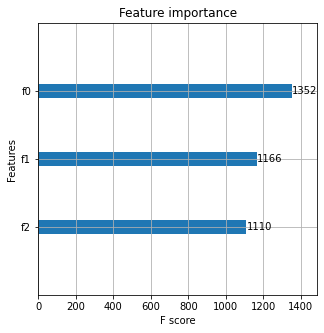

In [38]:
### plot feature importance
fig,ax = plt.subplots(figsize=(5,5))
plot_importance(model,
                height=0.2,
                ax=ax,
                max_num_features=6)
plt.show()

In [39]:
### make prediction for test data
y_pred = np.round(model.predict_proba(x_valid)[:,1])

### model evaluate
accuracy = accuracy_score(y_valid, y_pred)
print("accuarcy: {}".format((accuracy*100.0)))

accuarcy: 97.99941014549745


In [40]:
joblib.dump(model, 'xgboost.model')  #save model

['xgboost.model']

## Test data collection && features generation

In [41]:
from test_data_collator import TestDataCollator

In [42]:
test_batch = 32
test_data_file = "/data/suyinpei/test_data_1k.tsv"
bert_score_test_root = '/data/suyinpei/bert_score_test.pt'

In [43]:
test_data_collator = TestDataCollator(test_data_file)

In [46]:
test_dataloader = test_data_collator.load_data(test_batch, tokenizer, entity_to_index, index_to_entity, wiki2vec, idf_dict, unk_idf, 
                                    en_pad_size, en_embd_dim, entity_distribute_dict)

11/04/2020 08:08:18 - Encode text: Took 10.39155626296997 seconds
11/04/2020 08:08:20 - Encode entity: Took 1.733163595199585 seconds


In [47]:
bert_scorer_test = BertScorer(bert, test_dataloader)
entity_scorer_test = EntityScorer(entity_model, test_dataloader)

11/04/2020 08:08:20 - use device: cuda
11/04/2020 08:08:20 - use device: cuda


In [48]:
bert_score_test = bert_scorer_test.generate_score(bert_score_test_root)

Bert Score Progress: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


In [49]:
entity_score_test, entity_distribute_test = entity_scorer_test.generate_score(test=True)

Entity Model Score Progress: 100%|██████████| 32/32 [00:00<00:00, 154.74it/s]


## Predict

In [50]:
feature_processor = FeatureProcess()

In [51]:
test_features = feature_processor.load_features(bert_score_test_root, entity_score_test, entity_distribute_test)

11/04/2020 08:08:43 - Features shape: torch.Size([999, 3])


In [52]:
import joblib

In [53]:
model = joblib.load('xgboost.model') #load saved model

In [54]:
y_pred = model.predict_proba(test_features.numpy())[:,1]

In [56]:
logger.info('Predict number: {}'.format(y_pred.shape[0]))
for i in range(2):
    f = open(test_data_file)
    fout = open('../data/model_predict.tsv','w')
    reader = csv.reader(f, delimiter='\t')
    for line, prob in zip(reader, y_pred):
        docid = line[0]
        fout.write('{}\t{}\n'.format(docid, prob))         

11/04/2020 08:11:34 - Predict number: 999
